In [29]:
import pandas as pd

df=pd.read_excel('merged_teams_data.xlsx')

In [ ]:
def clean_club_worth(value):
    value = value.replace('€', '').lower()
    if value.endswith('b'):
        return float(value.replace('b', '')) * 1000 
    elif value.endswith('m'):
        return float(value.replace('m', ''))
    return float(value)

# Apply this to your DataFrame
df['club_worth_million'] = df['club_worth'].apply(clean_club_worth)

In [25]:
df['points_per_game'] = df['points'] / df['matches_played']

In [26]:
df.to_excel('merged_teams_data.xlsx', index=False)
print(f"✅ Data cleaned")

✅ Data cleaned


In [30]:
features = [
    'wins', 'overall', 'attack', 'midfield', 'defence',
    'club_worth_million_euro', 'domestic_prestige',
    'titles_won','goals_for', 'goals_against',
    'international_prestige', 'players', 'starting_xi_average_age'
]


In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['points_per_game'], test_size=0.2, random_state=42)


In [33]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [34]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MSE: 0.006907138145744494
R2 Score: 0.9730329878047838


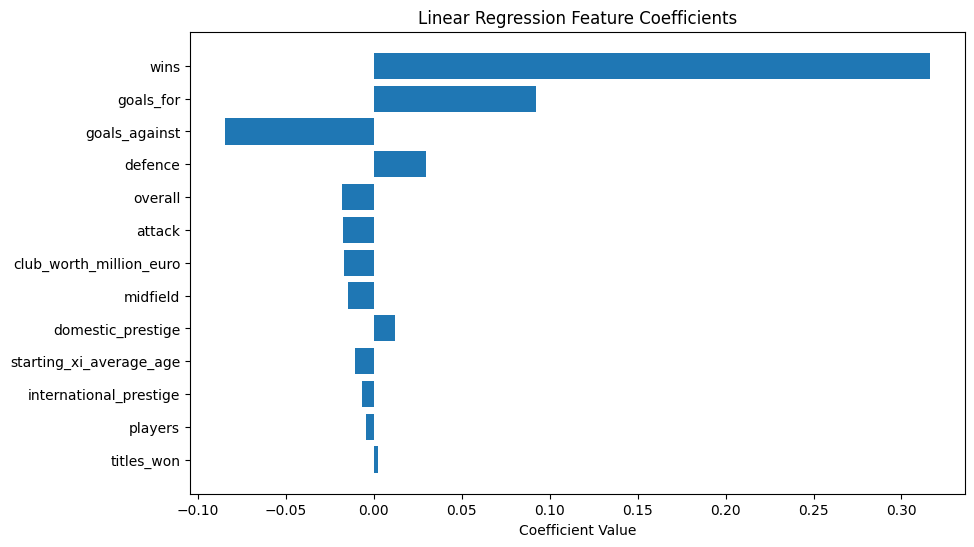

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'model' is your trained LinearRegression model
coefficients = model.coef_
features = df[features].columns  # Replace X with your actual DataFrame of features

coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

# Plot the coefficients
plt.figure(figsize=(10,6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Linear Regression Feature Coefficients')
plt.gca().invert_yaxis()
plt.show()




In [47]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Define features and target
X = df.drop(columns=['points_per_game','last_5','Picture'	,'league_sofascore','matched_team','speed', 'dribbling', 'passing', 'positioning',
    'crossing', 'shooting', 'aggression'])  # Replace 'ppg' with your actual target column
y = df['points_per_game']  # Replace 'ppg' with your actual target column

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# --- Step 1: VIF Calculation ---
print("\n--- VIF (Variance Inflation Factor) ---")
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
print(vif_data.sort_values(by="VIF", ascending=False))

# --- Step 2: Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Step 3: Fit Models and Compare ---
# Define and train models individually
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Linear
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Lasso
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train, y_train)

# Evaluate
for name, model in zip(
    ["Linear Regression", "Ridge Regression", "Lasso Regression"],
    [linear_model, ridge_model, lasso_model]
):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{name} Results:")
    print(f"  MSE: {mse:.5f}")
    print(f"  R2 Score: {r2:.5f}")



--- VIF (Variance Inflation Factor) ---
                    Feature        VIF
6                   overall  42.458310
0                      wins  22.184278
2                     losts  17.784692
8                  midfield  15.623222
9                   defence  12.929318
3                 goals_for   9.991253
12   international_prestige   8.895340
7                    attack   7.419941
11        domestic_prestige   6.943543
4             goals_against   5.114237
10  club_worth_million_euro   4.108089
1                     draws   3.457603
5                titles_won   2.500736
13                  players   1.549954
14  starting_xi_average_age   1.407624

Linear Regression Results:
  MSE: 0.00059
  R2 Score: 0.99769

Ridge Regression Results:
  MSE: 0.00079
  R2 Score: 0.99692

Lasso Regression Results:
  MSE: 0.00055
  R2 Score: 0.99787


Several features (matches_played, wins, draws, losts, diff, points, goals_for, goals_against) have VIF = ∞ → means perfect multicollinearity. This happens because these features are mathematically related

In [48]:
df = df.drop(columns=['matches_played', 'points', 'diff'], errors='ignore')

In [49]:
selected_features = pd.Series(lasso_model.coef_, index=X.columns)
print(selected_features[selected_features != 0])


wins         0.275734
draws       -0.002009
losts       -0.169198
goals_for    0.012978
dtype: float64


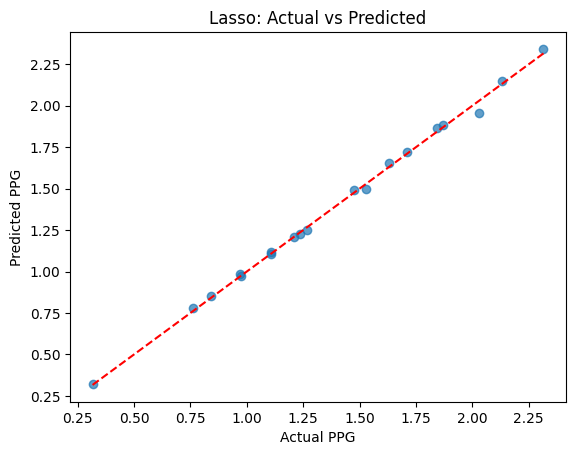

In [50]:
import matplotlib.pyplot as plt

y_pred = lasso_model.predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual PPG")
plt.ylabel("Predicted PPG")
plt.title("Lasso: Actual vs Predicted")
plt.show()


In [51]:
import joblib
joblib.dump(lasso_model, "models/ppg_lasso_model.pkl")
joblib.dump(scaler, "models/ppg_scaler.pkl")


['models/ppg_scaler.pkl']

In [52]:
columns = X.columns.tolist()
joblib.dump(columns, "models/ppg_feature_columns.pkl")


['models/ppg_feature_columns.pkl']